<a href="https://colab.research.google.com/github/vastandinfinite95/BP0306578-DATA-SCIENCE-PROFESSIONAL-PRACTICE-SUMMATIVE-SUBMISSION/blob/main/121_LR_ANALYSIS_PP_SEPTEMBER_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()


Saving 121 COLAB ANALYSIS.xlsx to 121 COLAB ANALYSIS (1).xlsx


In [3]:
import pandas as pd

df = pd.read_excel('121 COLAB ANALYSIS.xlsx', sheet_name='Main')


In [6]:
# Keep only Careers and Enterprise (case-insensitive, trims spaces)
df = df[df['Type'].astype(str).str.strip().str.lower().isin(['careers', 'enterprise'])].copy()

# --- Fix Attended -> 0/1 ---
# Normalise common labels first, then map to 0/1
attended_norm = (
    df['Attended'].astype(str).str.strip().str.lower()
      .replace({
          'no show': 'no',
          'noshow': 'no',
          'late cancellation': 'no',
          'cancelled': 'no',
          'canceled': 'no'
      })
)
df['Attended'] = attended_norm.map({
    'yes': 1, 'y': 1, 'true': 1, 't': 1, '1': 1,
    'no':  0, 'n': 0, 'false': 0, 'f': 0, '0': 0
})

# Drop any rows that still didn’t map (or were blank), then cast to int
df = df[df['Attended'].notna()].copy()
df['Attended'] = df['Attended'].astype(int)

# Treat missing 'Student Year' as 'N/A'
df['Student Year'] = df['Student Year'].fillna('N/A')

# --- Build Hour Label safely ---
# Coerce to numeric in case the column is stored as text or float
hour_num = pd.to_numeric(df['Hour Of Day'], errors='coerce')
df['Hour Label'] = hour_num.apply(lambda x: f"{int(x):02d}:00" if pd.notna(x) else 'Unknown')

# (Optional) Quick sanity checks
# print(df['Attended'].value_counts(dropna=False))
# print(df['Hour Label'].value_counts(dropna=False).head())

# df is now ready for modelling/visuals

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

def run_logistic_analysis(df, column, label_prefix, target='Attended', drop_first=True):
    # One-hot encode the chosen column
    X = pd.get_dummies(df[[column]], prefix=label_prefix, drop_first=drop_first)
    y = df[target]

    # Split and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    model = LogisticRegressionCV(cv=5, class_weight='balanced', max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    print(f"=== Logistic Regression on '{column}' ===")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Coefficients
    coeffs = pd.Series(model.coef_[0], index=X.columns).sort_values()
    coeffs.index = coeffs.index.str.replace(f'{label_prefix}_', '', regex=False)

    # Plot
    plt.figure(figsize=(8, 6))
    coeffs.plot(kind='barh', color='steelblue', edgecolor='black')
    plt.title(f'Effect of {column} on Log-Odds of Attendance')
    plt.xlabel('Log-Odds Impact')
    plt.axvline(0, linestyle='--', color='grey')
    plt.grid(axis='x', linestyle=':')
    plt.tight_layout()
    plt.show()


=== Logistic Regression on 'Hour Label' ===
Accuracy: 0.494
Precision: 0.716
Recall: 0.476
Confusion Matrix:
 [[36 31]
 [86 78]]


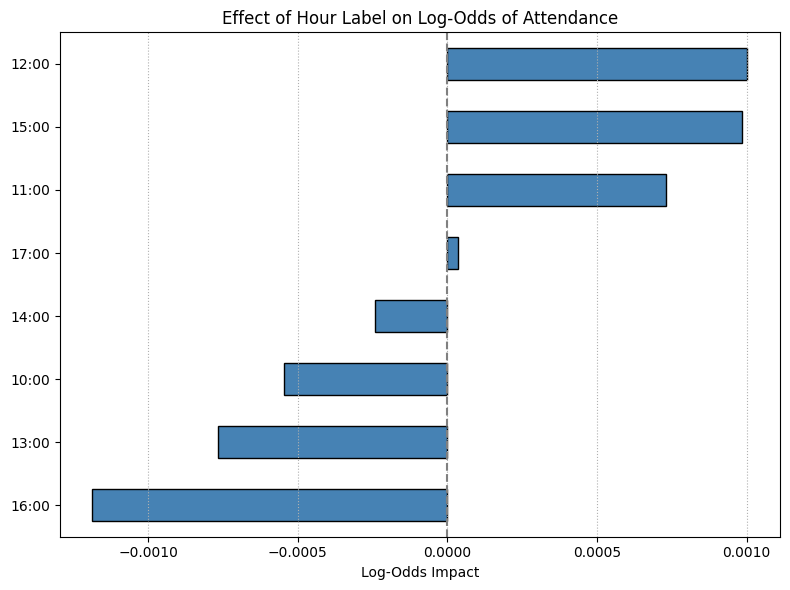

In [8]:
run_logistic_analysis(df, column='Hour Label', label_prefix='Hour')


=== Logistic Regression on 'Day Of The Week' ===
Accuracy: 0.463
Precision: 0.696
Recall: 0.433
Confusion Matrix:
 [[36 31]
 [93 71]]


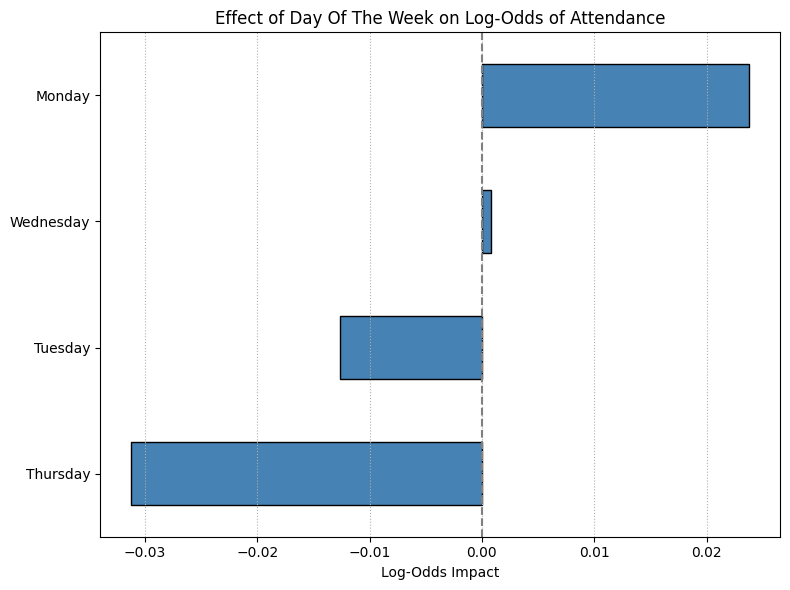

In [9]:
run_logistic_analysis(df, column='Day Of The Week', label_prefix='Day')


=== Logistic Regression on 'Student Year' ===
Accuracy: 0.519
Precision: 0.719
Recall: 0.53
Confusion Matrix:
 [[33 34]
 [77 87]]


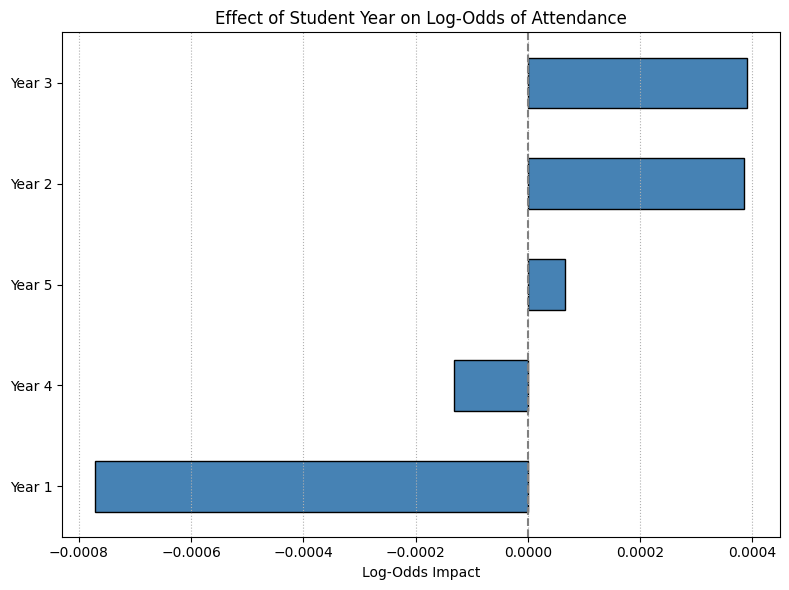

In [10]:
run_logistic_analysis(df, column='Student Year', label_prefix='Year')


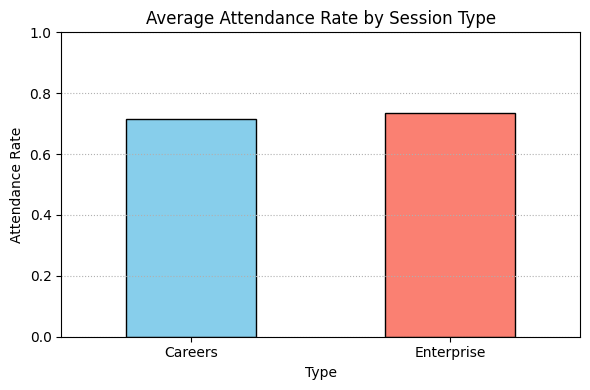

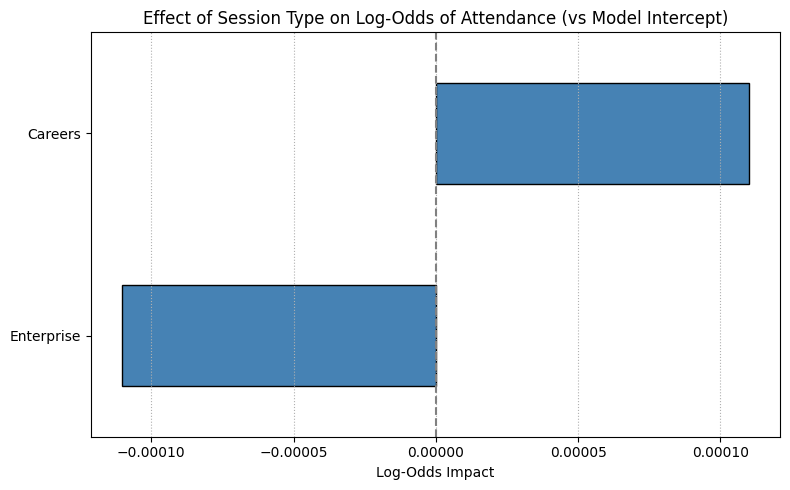

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

# === 1. Group attendance rate comparison ===
type_attendance = df.groupby('Type')['Attended'].mean().sort_values()

plt.figure(figsize=(6, 4))
type_attendance.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.title('Average Attendance Rate by Session Type')
plt.ylabel('Attendance Rate')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()

# === 2. Logistic Regression ===
# One-hot encode both Careers and Enterprise (no drop_first)
X_type_full = pd.get_dummies(df[['Type']], prefix='Type', drop_first=False)
y_type = df['Attended']

X_train, X_test, y_train, y_test = train_test_split(X_type_full, y_type, random_state=42)

model_type_full = LogisticRegressionCV(cv=5, class_weight='balanced', max_iter=1000, random_state=42)
model_type_full.fit(X_train, y_train)

# Coefficients with both types shown
coeffs_type = pd.Series(model_type_full.coef_[0], index=X_type_full.columns).sort_values()
coeffs_type.index = coeffs_type.index.str.replace('Type_', '', regex=False)

plt.figure(figsize=(8, 5))
coeffs_type.plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Effect of Session Type on Log-Odds of Attendance (vs Model Intercept)')
plt.xlabel('Log-Odds Impact')
plt.axvline(0, linestyle='--', color='grey')
plt.grid(axis='x', linestyle=':')
plt.tight_layout()
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

y_pred = model_type_full.predict(X_test)

print("=== Evaluation: Logistic Regression on 'Type' ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== Evaluation: Logistic Regression on 'Type' ===
Accuracy: 0.476
Precision: 0.669
Recall: 0.518
Confusion Matrix:
 [[25 42]
 [79 85]]


<>:42: SyntaxWarning: invalid escape sequence '\|'
<>:42: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-1989742637.py:42: SyntaxWarning: invalid escape sequence '\|'
  interaction_matrix[['Hour', 'Day']] = interaction_matrix['Hour_Day'].str.split(' \| ', expand=True)


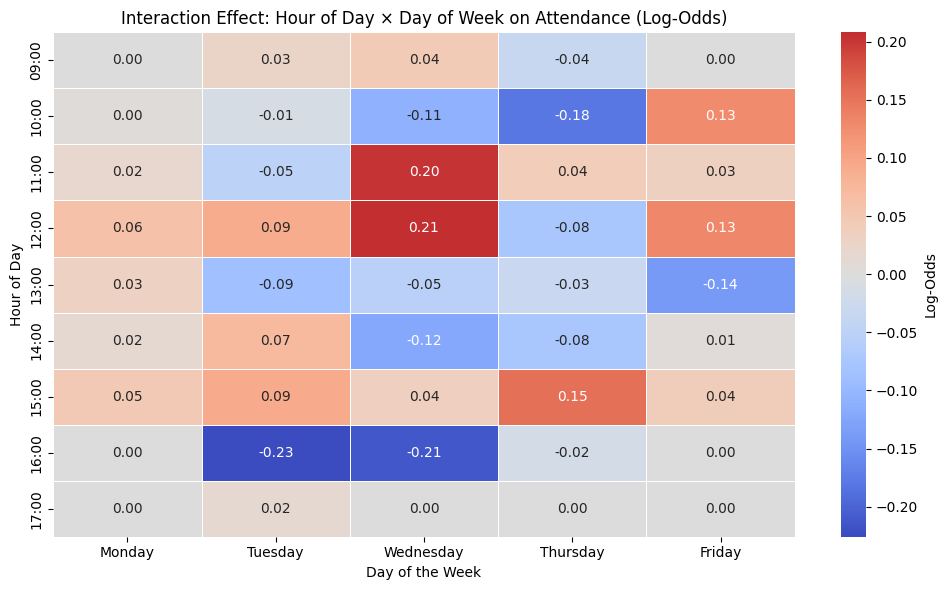

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

# --- 1) Clean day/hour + keep weekdays only ---
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df = df.copy()
df['Day'] = df['Day Of The Week'].astype(str).str.strip().str.title()
df = df[df['Day'].isin(weekday_order)].copy()

# Numeric hour, then zero-padded label like 09:00
hour_num = pd.to_numeric(df['Hour Of Day'], errors='coerce').astype('Int64')
df = df[hour_num.notna()].copy()
df['Hour_Num'] = hour_num.astype(int)
df['Hour Label'] = df['Hour_Num'].apply(lambda h: f"{h:02d}:00")

# Build ordered hour category from actual hours present, sorted morning→afternoon
hour_order = [f"{h:02d}:00" for h in sorted(df['Hour_Num'].unique())]

# --- 2) Interaction + dummies ---
df['Hour_Day'] = df['Hour Label'] + ' | ' + df['Day']
X_interact = pd.get_dummies(df['Hour_Day'], prefix='Int', drop_first=True)
y_interact = df['Attended'].astype(int)

# --- 3) Train model ---
X_train, X_test, y_train, y_test = train_test_split(X_interact, y_interact, random_state=42)
model_interact = LogisticRegressionCV(cv=5, class_weight='balanced', max_iter=1000, random_state=42)
model_interact.fit(X_train, y_train)

# --- 4) Coefficients -> full Hour×Day grid (include baseline as 0) ---
coef_series = pd.Series(model_interact.coef_[0], index=X_interact.columns)
coef_series.index = coef_series.index.str.replace('Int_', '', regex=False)

all_keys = [f"{h} | {d}" for h in hour_order for d in weekday_order]
full_coefs = pd.Series(0.0, index=all_keys, name='coef')
full_coefs.loc[coef_series.index] = coef_series.values

interaction_matrix = full_coefs.reset_index().rename(columns={'index': 'Hour_Day'})
interaction_matrix[['Hour', 'Day']] = interaction_matrix['Hour_Day'].str.split(' \| ', expand=True)

# Ordered categoricals ensure correct sorting on axes
interaction_matrix['Hour'] = pd.Categorical(interaction_matrix['Hour'], categories=hour_order, ordered=True)
interaction_matrix['Day']  = pd.Categorical(interaction_matrix['Day'],  categories=weekday_order, ordered=True)

# --- 5) Pivot in desired order and plot ---
pivot_table = (interaction_matrix
               .pivot(index='Hour', columns='Day', values='coef')
               .reindex(index=hour_order, columns=weekday_order))

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,  # or (pivot_table * 1000) if you prefer ×1000 scaling
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Log-Odds'}
)
plt.title('Interaction Effect: Hour of Day × Day of Week on Attendance (Log-Odds)')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()


In [14]:
# Count how many sessions exist per Hour × Day
df['Hour Label'] = df['Hour Of Day'].astype(str) + ':00'
session_counts = df.groupby(['Hour Label', 'Day Of The Week']).size().unstack(fill_value=0)
print(session_counts)


Day Of The Week  Friday  Monday  Thursday  Tuesday  Wednesday
Hour Label                                                   
10:00                35       4        47       34         54
11:00                34       7        23       31         48
12:00                16       4        19       10         29
13:00                23       3        40       37         13
14:00                26       1        33       50         25
15:00                18       9        25       36         16
16:00                 0       0        18       27         10
17:00                 0       0         0        1          0
9:00                 30       0         8       19         60


The white cells in the heatmap indicate missing values in the interaction matrix. These happen because:

⚠️ There were no 1-2-1 sessions recorded at those Hour × Day combinations in your dataset.

For example, if no session took place at 10:00 on Monday, then the model can’t estimate a coefficient for that combo, so the cell is left blank (white) in the heatmap.

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Use existing model and test set
y_pred = model_interact.predict(X_test)

print("=== Evaluation: Logistic Regression on Hour × Day Interaction ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== Evaluation: Logistic Regression on Hour × Day Interaction ===
Accuracy: 0.502
Precision: 0.687
Recall: 0.549
Confusion Matrix:
 [[26 41]
 [74 90]]


<>:57: SyntaxWarning: invalid escape sequence '\|'
<>:57: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-3240730268.py:57: SyntaxWarning: invalid escape sequence '\|'
  interaction_matrix[['Year', 'Day']] = interaction_matrix['Year_Day'].str.split(' \| ', expand=True)


Day       Monday   Tuesday  Wednesday  Thursday    Friday
Year                                                     
nan     0.000206 -0.000003  -0.000234 -0.000117  0.000273
Year 1  0.000251 -0.000712  -0.000183  0.000130  0.000000
Year 2 -0.000081  0.000100   0.000250 -0.000176  0.000295
Year 3  0.000034  0.000466  -0.000053 -0.000062  0.000006
Year 4  0.000000 -0.000081   0.000274 -0.000380  0.000056


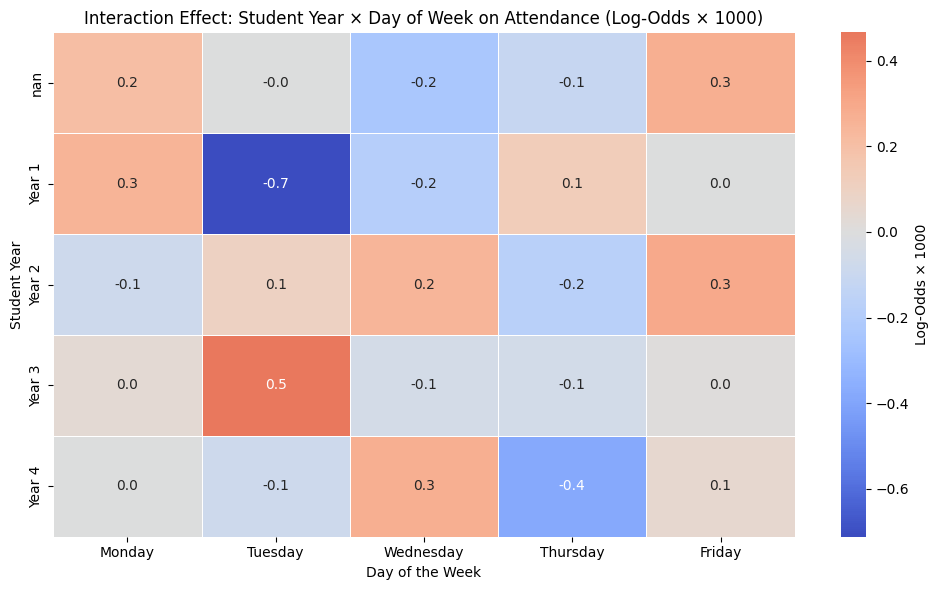

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

# =========================
# 0) PREP
# =========================
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
year_order = ['nan', 'Year 1', 'Year 2', 'Year 3', 'Year 4']  # desired y-axis order
valid_years = year_order[1:]  # Year 1..Year 4

# Ensure Day column is clean and filter to weekdays
df['Day'] = df['Day Of The Week'].astype(str).str.strip().str.title()
df = df[df['Day'].isin(weekday_order)].copy()

# =========================
# 1) Build a 5-level year with 'nan' bucket
#    (keep only Year1-4; everything else -> NaN, then label 'nan')
# =========================
yr = df['Student Year']
yr = yr.where(yr.isin(valid_years))  # all non Year1-4 become NaN
df['Year5'] = yr.fillna('nan')

# Make ordered categoricals for sorting downstream
df['Year5'] = pd.Categorical(df['Year5'], categories=year_order, ordered=True)
df['Day']   = pd.Categorical(df['Day'],   categories=weekday_order, ordered=True)

# =========================
# 2) Interaction, dummies, model
# =========================
df['Year_Day'] = df['Year5'].astype(str) + ' | ' + df['Day'].astype(str)

X_interact = pd.get_dummies(df['Year_Day'], prefix='Int', drop_first=True)
y_interact = df['Attended'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_interact, y_interact, random_state=42)
model_interact_yrday = LogisticRegressionCV(
    cv=5, class_weight='balanced', max_iter=1000, random_state=42
)
model_interact_yrday.fit(X_train, y_train)

# =========================
# 3) Coefficients → full grid (include dropped baseline as 0)
# =========================
coef_series = pd.Series(model_interact_yrday.coef_[0], index=X_interact.columns)
coef_series.index = coef_series.index.str.replace('Int_', '', regex=False)

# Build a full set of Year×Day keys initialised to 0 (baseline)
all_keys = [f'{y} | {d}' for y in year_order for d in weekday_order]
full_coefs = pd.Series(0.0, index=all_keys, name='coef')
full_coefs.loc[coef_series.index] = coef_series.values

interaction_matrix = full_coefs.reset_index().rename(columns={'index': 'Year_Day'})
interaction_matrix[['Year', 'Day']] = interaction_matrix['Year_Day'].str.split(' \| ', expand=True)
interaction_matrix['Year'] = pd.Categorical(interaction_matrix['Year'], categories=year_order, ordered=True)
interaction_matrix['Day']  = pd.Categorical(interaction_matrix['Day'],  categories=weekday_order, ordered=True)

# =========================
# 4) Pivot in the required order and plot
# =========================
pivot_table = (interaction_matrix
               .pivot(index='Year', columns='Day', values='coef')
               .reindex(index=year_order, columns=weekday_order))

print(pivot_table)  # now valid: prints the matrix you'll plot

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table * 1000,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': 'Log-Odds × 1000'}
)
plt.title('Interaction Effect: Student Year × Day of Week on Attendance (Log-Odds × 1000)')
plt.xlabel('Day of the Week')
plt.ylabel('Student Year')
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

y_pred = model_interact_yrday.predict(X_test)

print("=== Evaluation: Logistic Regression on Student Year × Day of Week ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== Evaluation: Logistic Regression on Student Year × Day of Week ===
Accuracy: 0.512
Precision: 0.725
Recall: 0.527
Confusion Matrix:
 [[27 30]
 [71 79]]


What This Graph Shows:
Analysed how student year and day of the week interact to affect attendance at 1-2-1 sessions.

What Data Analyst Did:
Combined Student Year and Day into one variable (e.g. Year 2 x Tuesday).

Used logistic regression to estimate how each combination affects the likelihood of attendance.

Plotted the results in a heatmap, with values scaled ×1000 for readability.

Why It Matters:
This helps identify which year groups attend more or less on specific days supporting smarter scheduling and outreach planning.